# Importing libraries

In [1]:
import os
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.set_visible_devices([gpus[0]], 'GPU')
        tf.config.experimental.set_memory_growth(gpus[0], True)
        print("Using GPU:", gpus[0])
    except RuntimeError as e:
        print(e)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix

Using GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


# Preprocessing & loading data

In [2]:
batch_size = 16

train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
)

val_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_generator = train_datagen.flow_from_directory(
    "dataset/train",
    target_size=(416, 416),
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    "dataset/valid",
    target_size=(416, 416),
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    "dataset/test",
    target_size=(416, 416),
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

Found 11793 images belonging to 4 classes.
Found 1123 images belonging to 4 classes.
Found 562 images belonging to 4 classes.


# Building model

In [3]:
model = Sequential([
    Input(shape=(416, 416, 3), name="input_layer"),

    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax', name="output_layer")
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 416, 416, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 208, 208, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 208, 208, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 104, 104, 64)     0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 104, 104, 128)     73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 52, 52, 128)      0

# Training model & compile model

In [4]:
model.compile(
    loss="categorical_crossentropy", 
    optimizer=Adam(learning_rate=0.001),
    metrics=["accuracy"]
)

early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6)

history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/10
738/738 [==============================] - 174s 232ms/step - loss: 1.1050 - accuracy: 0.5241 - val_loss: 0.8769 - val_accuracy: 0.6892 - lr: 0.0010
Epoch 2/10
738/738 [==============================] - 94s 127ms/step - loss: 0.6229 - accuracy: 0.7497 - val_loss: 0.3693 - val_accuracy: 0.8744 - lr: 0.0010
Epoch 3/10
738/738 [==============================] - 91s 123ms/step - loss: 0.5111 - accuracy: 0.7989 - val_loss: 0.4048 - val_accuracy: 0.8201 - lr: 0.0010
Epoch 4/10
738/738 [==============================] - 92s 125ms/step - loss: 0.4284 - accuracy: 0.8342 - val_loss: 0.3148 - val_accuracy: 0.8940 - lr: 0.0010
Epoch 5/10
738/738 [==============================] - 97s 131ms/step - loss: 0.3829 - accuracy: 0.8498 - val_loss: 0.3348 - val_accuracy: 0.8833 - lr: 0.0010
Epoch 6/10
738/738 [==============================] - 93s 126ms/step - loss: 0.3685 - accuracy: 0.8605 - val_loss: 0.2825 - val_accuracy: 0.9047 - lr: 0.0010
Epoch 7/10
738/738 [==============================]

# Evaluating model

In [5]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

36/36 [==============================] - 7s 199ms/step - loss: 0.2298 - accuracy: 0.9093
Test Accuracy: 0.9093
Test Loss: 0.2298


36/36 [==============================] - 4s 117ms/step


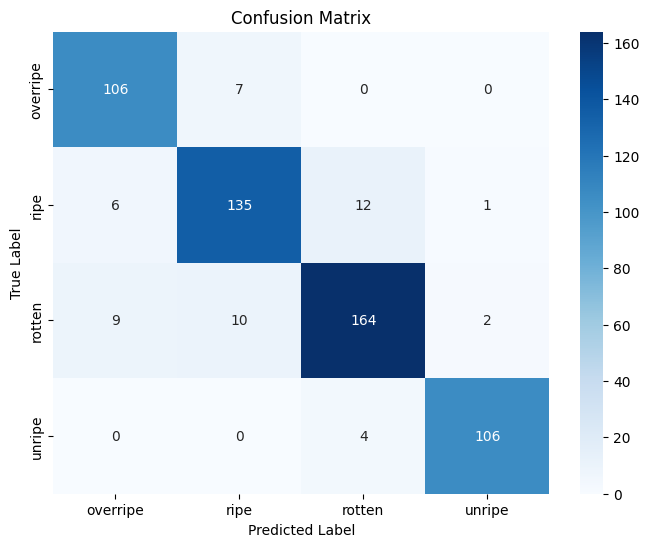

Classification Report:
              precision    recall  f1-score   support

    overripe       0.88      0.94      0.91       113
        ripe       0.89      0.88      0.88       154
      rotten       0.91      0.89      0.90       185
      unripe       0.97      0.96      0.97       110

    accuracy                           0.91       562
   macro avg       0.91      0.92      0.91       562
weighted avg       0.91      0.91      0.91       562



In [11]:
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

y_true = test_generator.classes

class_labels = list(test_generator.class_indices.keys())

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

## Visualizing model accuracy & loss

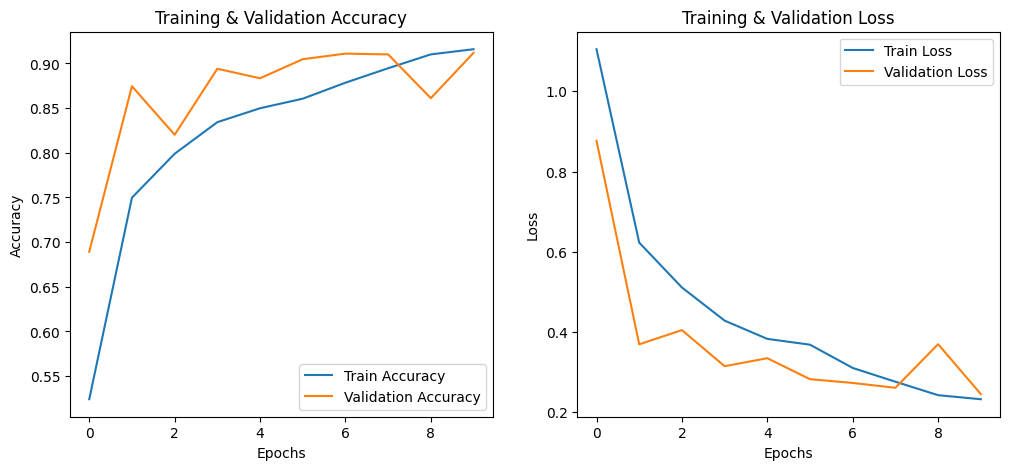

In [7]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training & Validation Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()

plt.show()

# Saving model

In [8]:
model.save("banana_ripeness_model")

INFO:tensorflow:Assets written to: banana_ripeness_model\assets


INFO:tensorflow:Assets written to: banana_ripeness_model\assets


In [9]:
import tensorflow.lite as tflite

converter = tf.lite.TFLiteConverter.from_saved_model("banana_ripeness_model")
tflite_model = converter.convert()

with open("banana_ripeness_model.tflite", "wb") as f:
    f.write(tflite_model)

## Switch environment to tfjs-env

#### saving model to tfjs model

In [1]:
import tensorflowjs as tfjs

tfjs.converters.convert_tf_saved_model("saved_model", "tfjs_model")

Writing weight file tfjs_model\model.json...


# Note:
I couldn't save the model in tfjs at the same environment due to dependency issues. I'm using tensorflow 2.10 in the train-env, and it conflicts with tensorflowjs newer version. why tensorflow 2.10? because the training with CPU takes 1 hour per epoch which is too long. so I used GPU, and I used tensorflow directml plugin, which requires me to use tensorflow 2.10